# Exercise Sheet 6: Autoencoder

In [1]:
import os
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import random
import time

# Import PyTorch
import torch
import torch.nn as nn

# Load FashionMNIST dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid

# set figure size
plt.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# set random seed
random.seed(42)
torch.manual_seed(42)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


########################
########################

# set hyperparameters
EPOCHS = 50
EPOCHS_NOISE = 50
BATCH_SIZE = 128
TEST_BATCH_SIZE = 10
LEARNING_RATE = 1e-3
MOMENTUM = 1e-5

# set directories
RESULTS_DIR = 'results/'
DATA_DIR = 'data/'
MODEL_DIR = 'models/'

########################
########################


# if don't exist, create directories
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

Using device: cpu


### Utility Functions and Classes

In [4]:
def to_img(x, shape=(28, 28)):
    """ Maps a 2D tensor from range [-1, 1] to 4D tensor with range [0, 1].
    Useful for plotting of reconstructions.

    :param x: 2D Tensor that is supposed to be converted
    :return: Converted 4D Tensor with b, c, w, h, where w = h = 28
    """
    x = 0.5 * (x + 1) # mode to range [0, 1]
    x = x.clamp(0, 1) # clip boundaries
    x = x.view(x.size(0), 1, shape[0], shape[1]) # reshape
    return x


def add_white_noise(x, factor=0.5, stddev=1):
    """ Adds white noise to an input tensor.
    To make sure that data is in intended range [min, max], use torch.clamp(x, min, max) after applying this function.

    :param x: ND Tensor that is altered
    :param factor: A factor that controls the strength of the additive noise
    :param stddev: The stddev of the normal distribution used for generating the noise
    :return: ND Tensor, x with white noise
    """
    # add white noise to tensor
    noise = torch.randn_like(x) * stddev
    return x + (noise * factor)

#### Data Preparation

In [5]:
train_mean, train_std = (0.5,), (0.5,)

# Load FashionMNIST dataset & apply transformations for noisy and clean data
# Define a transform to normalize the data
transform_clean = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.Resize(28),  # Resize to 28x28
                                transforms.ToTensor(),
                                transforms.Normalize(train_mean, train_std)])

# Define a transform with noise to the data
transform_noise = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.Resize(28),  # Resize to 28x28
                                transforms.Lambda(lambda x: add_white_noise(x, factor=0.5, stddev=1)),
                                transforms.ToTensor(),
                                transforms.Normalize(train_mean, train_std)])

# Download and load the training data
trainset = datasets.FashionMNIST(DATA_DIR, download=True, train=True, transform=transform_clean)
trainset_noise = datasets.FashionMNIST(DATA_DIR, download=True, train=True, transform=transform_noise)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
trainloader_noise = torch.utils.data.DataLoader(trainset_noise, batch_size=BATCH_SIZE, shuffle=True)


# Download and load the test data
testset = datasets.FashionMNIST(DATA_DIR, download=True, train=False, transform=transform_clean)
testset_noise = datasets.FashionMNIST(DATA_DIR, download=True, train=False, transform=transform_noise)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)
testloader_noise = torch.utils.data.DataLoader(testset_noise, batch_size=BATCH_SIZE, shuffle=True)


100%|██████████| 26421880/26421880 [00:08<00:00, 2970875.47it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268767.57it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4997161.66it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11281231.45it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



<ipython-input-6-930870869b66>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, i + 1)
<ipython-input-6-930870869b66>:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, i + 1)


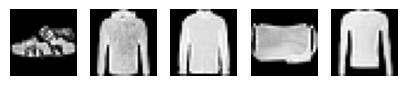

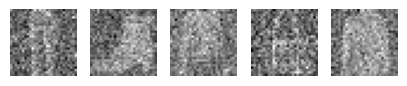

In [6]:
# Plot 5 training images for trainloader and trainloader_noise - no labels
# Set the number of images to plot
num_images = 5

# Plot the images from trainloader
plt.figure(figsize=(num_images, 2))
plt.title('FashionMNIST images (clean)')
# place it on GPU if available
dataiter = iter(trainloader)
for i in range(num_images):
    # Get the next batch of images
    images, _ = next(dataiter)

    # Plot the first image in the batch
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.axis('off')

# Plot the images from trainloader_noise
dataiter_noise = iter(trainloader_noise)  # Create an iterator for trainloader_noise
plt.figure(figsize=(num_images, 2))
plt.title('FashionMNIST images (noisy)')
for i in range(num_images):
    # Get the next batch of images
    images, _ = next(dataiter_noise)

    # Plot the first image in the batch
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.axis('off')

# Plot the images from testloader
plt.show()

### Task 1: Implement a Linear Autoencoder

In [7]:

class Encoder(nn.Module):
    """Encoder network for the Autoencoder"""

    def __init__(self, input_shape=(28, 28)):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(np.prod(input_shape), 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

class Decoder(nn.Module):
    """Decoder network for the Autoencoder"""

    def __init__(self, input_shape=(28, 28)):
        super(Decoder, self).__init__()
        self.input_shape = input_shape
        self.decoder = nn.Sequential(
            nn.Linear(8, 8),  #(8, 16)
            nn.ReLU(),
            nn.Linear(8, 32), #(16, 32)
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, np.prod(input_shape)),
            nn.Tanh(), # mapping output to -1, 1 range
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

class Autoencoder(nn.Module):
    """ Linear Autoencoder Network"""

    def __init__(self, input_shape=(28, 28)):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_shape)
        self.decoder = Decoder(input_shape)

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [8]:
# 1.1 Implement a fully-connected autoencoder using the class torch.nn.Module2 from pytorch. Use the provided starter code as a template
autoencoder = Autoencoder(input_shape=(28, 28))
autoencoder.to(device)

print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): ReLU(inplace=True)
      (6): Linear(in_features=32, out_features=16, bias=True)
      (7): ReLU(inplace=True)
      (8): Linear(in_features=16, out_features=8, bias=True)
      (9): ReLU(inplace=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=8, out_features=32, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=32, out_features=64, bias=True)
      (5): ReLU(inplace=True)
      (6): Linear(in_features=64, out_features=128, bias=True)
      (7): ReLU(inplace=True)
      (8): Linear(in_features=128, out_features=784

In [9]:
def plot_samples(samples, path='img.png', figsize=(15, 6)):
    """ Plot 10 samples with their reconstructions """
    n_samples = len(samples)
    fig, axes = plt.subplots(2, n_samples, figsize=figsize)
    axes = axes.flatten()
    fig.suptitle('Input Samples and their Reconstructions')

    for i, (input_img, reconstructed_img) in enumerate(samples):
        # Plot the input image
        axes[i].imshow(input_img.numpy().squeeze(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Input Image {i+1}', fontsize=7)

        # Plot the reconstructed image
        axes[i+n_samples].imshow(reconstructed_img.numpy().squeeze(), cmap='gray')
        axes[i+n_samples].axis('off')
        axes[i+n_samples].set_title(f'Reconstructed Image {i+1}', fontsize=7)

    plt.subplots_adjust(wspace=0.1)
    plt.savefig(path)
    plt.show()

In [10]:
# 1.2 Use the mean squared error3 to implement the reconstruction error of the autoencoder.
# Train loop
def train(model, train_loader, optimizer, criterion, epoch, noise=False, device='cpu'):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):

        # reshape to vector
        data = data.view(data.size(0), -1)
        data = data.to(device)

        # added noise to the inputs
        if noise:
            # mean square error with tanh activation in output - values are restricted to range [-1, 1]
            inputs_in = data.clone()
            inputs_in.clamp_(-train_mean[0]/train_std[0], (1-train_mean[0])/train_std[0])
        else:
            inputs_in = data

        # forward pass: evaluate with model
        outputs = model(inputs_in)
        loss = criterion(outputs, data)

        # backward pass: compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # update weights

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    return model


# Test loop
def test(model, test_loader, noise=False, show_plot=False, device='cpu'):
    model.eval()
    test_loss = 0

    for i, (data, target) in enumerate(test_loader):
        # reshape to vector
        data = data.view(data.size(0), -1)
        data = data.to(device)

        # added noise to the inputs
        if noise:
            # mean square error with tanh activation in output - values are restricted to range [-1, 1]
            inputs_in = data.clone()
            inputs_in.clamp_(-train_mean[0]/train_std[0], (1-train_mean[0])/train_std[0])
        else:
            inputs_in = data
        # forward pass: evaluate with model
        outputs = model(inputs_in)
        test_loss += nn.MSELoss(size_average=False)(outputs, data).item() # sum up batch loss

        if show_plot == 1 and i == 0:
            inp = make_grid(to_img(inputs_in.cpu().data))
            out = make_grid(to_img(outputs.cpu().data))
            target = make_grid(to_img(data.cpu().data))
            if noise:
                plt.imshow(transforms.ToPILImage()(inp))
                plt.axis('off')
                plt.show()
            plt.imshow(transforms.ToPILImage()(out))
            plt.axis('off')
            plt.show()
            plt.imshow(transforms.ToPILImage()(target))
            plt.axis('off')
            plt.show()

    # calculate average loss per epoch
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

    return test_loss


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.673502
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.260889
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.171807
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.160999
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.145861


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


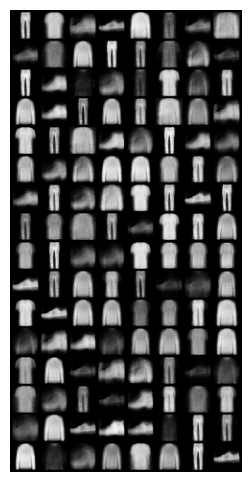

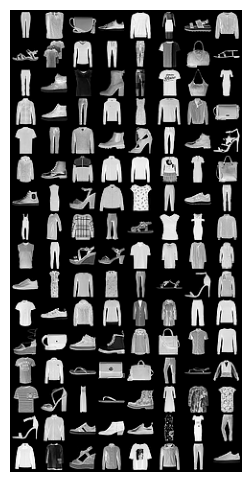


Test set: Average loss: 106.3578

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.134218
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.133776
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.116218
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.123891
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.109744

Test set: Average loss: 88.3188

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.111438
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.114692
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.110098
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.118708
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.107740

Test set: Average loss: 84.3072

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.114677
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.096791
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.102452
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.099364
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.105503

Test set: Average loss: 81.7800

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.099176
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.106224
Train Epoch: 5 [25600/60000 (43%)

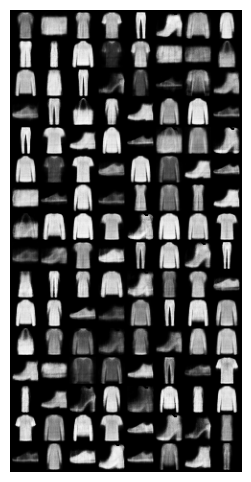

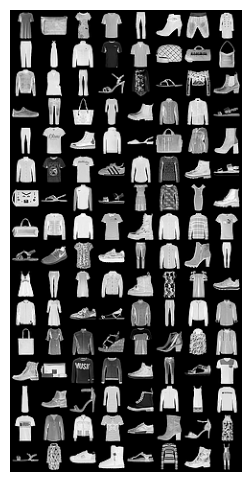


Test set: Average loss: 65.6520

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.082152
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.086162
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.084019
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.078958
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.075958

Test set: Average loss: 64.6688

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.090971
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.088847
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.081465
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.079160
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.083664

Test set: Average loss: 63.8088

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.077360
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.072650
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.080525
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.086252
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.079573

Test set: Average loss: 63.2343

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.080490
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.076456
Train Epoch: 15 [

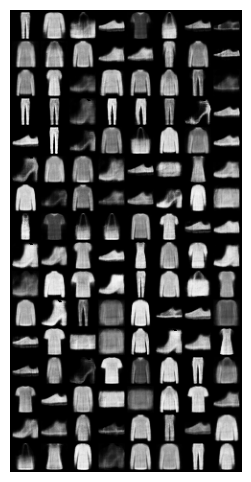

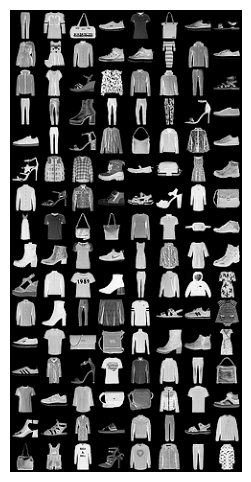


Test set: Average loss: 60.1418

Train Epoch: 22 [0/60000 (0%)]	Loss: 0.077493
Train Epoch: 22 [12800/60000 (21%)]	Loss: 0.079786
Train Epoch: 22 [25600/60000 (43%)]	Loss: 0.075095
Train Epoch: 22 [38400/60000 (64%)]	Loss: 0.076577
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.076477

Test set: Average loss: 59.4587

Train Epoch: 23 [0/60000 (0%)]	Loss: 0.072840
Train Epoch: 23 [12800/60000 (21%)]	Loss: 0.071092
Train Epoch: 23 [25600/60000 (43%)]	Loss: 0.073924
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.075107
Train Epoch: 23 [51200/60000 (85%)]	Loss: 0.069302

Test set: Average loss: 59.1712

Train Epoch: 24 [0/60000 (0%)]	Loss: 0.069115
Train Epoch: 24 [12800/60000 (21%)]	Loss: 0.079515
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.077516
Train Epoch: 24 [38400/60000 (64%)]	Loss: 0.082003
Train Epoch: 24 [51200/60000 (85%)]	Loss: 0.079616

Test set: Average loss: 58.7657

Train Epoch: 25 [0/60000 (0%)]	Loss: 0.067984
Train Epoch: 25 [12800/60000 (21%)]	Loss: 0.069718
Train Epoch: 25 [

In [11]:
# 1.3 For training use Adam as optimizer with a learning rate of 0.001, weight decay of 1e −5 and a batch size of 128.
# -- Run it for at least 50 epochs.
lr = 0.001
momentum = 1e-5
best_loss = 1000. # something large
noise = False

# Initialize optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=momentum) # Adam optimizer
# Use mean squared error (MSE) loss as reconstruction loss
criterion = nn.MSELoss()

# store train/test losses
train_losses = []
test_losses = []

# train the model
for epoch in range(1, EPOCHS + 1):
    start = time.time()
    model = train(autoencoder, trainloader, optimizer, criterion, epoch=epoch, noise=noise, device=device)
    test_loss = test(model, testloader, noise=noise, show_plot=epoch%10 == 1, device=device)
    # store losses
    if test_loss < best_loss:
        best_loss = test_loss
        if noise:
            torch.save(autoencoder.state_dict(), 'best_fc_denoising_autoencoder.pth')
        else:
            torch.save(autoencoder.state_dict(), 'best_fc_autoencoder.pth')

    test_losses.append(test_loss)

print('The best(lowest) achieved loss: {:.3f}\n'.format(best_loss))

In [12]:
def plot_latent(autoencoder, data, num_batches=128, path='latent.png', figsize=(4, 3), device='cpu'):
    z_list = []
    y_list = []

    autoencoder.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data):
            data = data.view(data.size(0), -1)
            inputs = data.to(device)

            if i >= num_batches:
                break
            
            z = autoencoder.encoder(inputs.to(device))
            z_list.append(z.cpu().numpy())
            y_list.append(target.numpy())

    z = np.concatenate(z_list, axis=0)
    y = np.concatenate(y_list, axis=0)

    plt.figure(figsize=figsize)
    scatter = plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
    plt.colorbar(scatter)
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space')
    plt.savefig(path)
    plt.show()

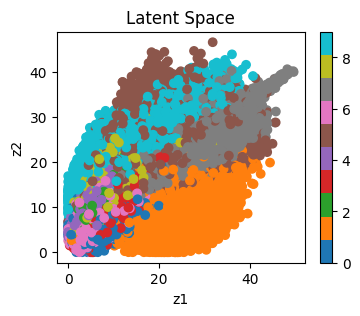

In [13]:
# Plot the latent space
plot_latent(autoencoder, trainloader, num_batches=BATCH_SIZE, path=f'{RESULTS_DIR}ae_latent.png', device=device)

In [14]:
# Report the training and validation loss of the autoencoder every ten epochs.
def plot_loss(test_losses, label='Loss curve',figsize=(5, 4), path='loss.png'):
    """ Plot test and training loss into the same plot """

    plt.figure(figsize=figsize)  # set the figure size
    plt.plot(test_losses, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(label)
    plt.legend()
    plt.savefig(path)
    plt.show()

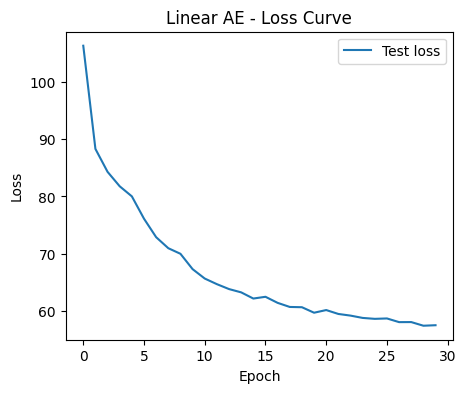

In [15]:
plot_loss(test_losses, label='Linear AE - Loss Curve', path=RESULTS_DIR+'ae_loss_curve.png')

## Task 2: Denoising Autoencoders

2.1 Use your code for the previous task. The model stays the same. But instead of the original input apply your network to the noised input (see function add noise in network.py)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.708444
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.249075
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.193454
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.166654
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.137674


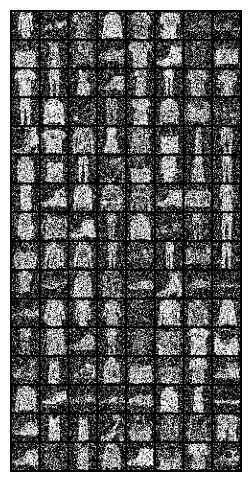

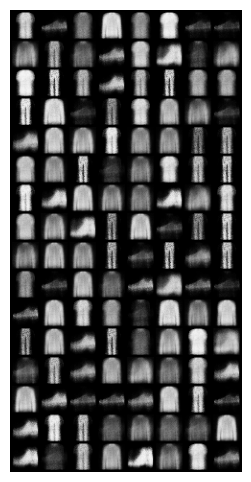

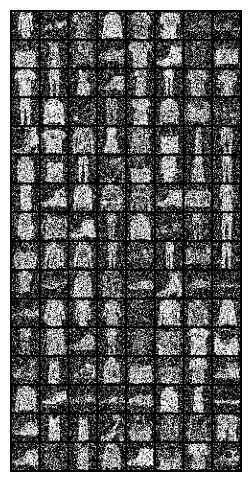


Test set: Average loss: 904.2389

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.168148
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.137620
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.142976
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.142014
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.129218

Test set: Average loss: 882.2788

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.131156
Train Epoch: 3 [12800/60000 (21%)]	Loss: 1.122218
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.121354
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.123952
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.122798

Test set: Average loss: 872.7197

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.110044
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1.126469
Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.109858
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.100499
Train Epoch: 4 [51200/60000 (85%)]	Loss: 1.100921

Test set: Average loss: 862.1343

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.097764
Train Epoch: 5 [12800/60000 (21%)]	Loss: 1.096796
Train Epoch: 5 [25600/60000 (4

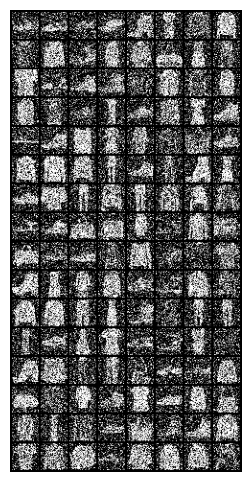

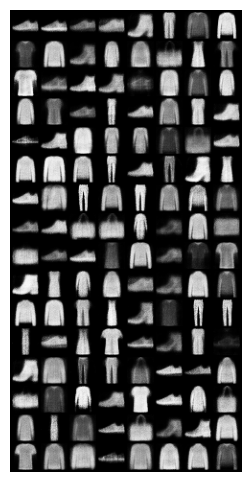

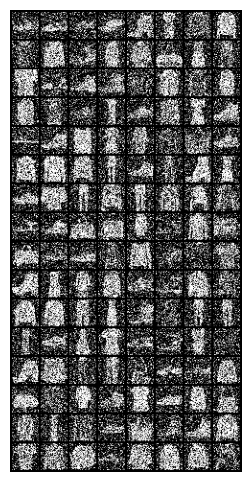


Test set: Average loss: 851.0794

Train Epoch: 12 [0/60000 (0%)]	Loss: 1.088452
Train Epoch: 12 [12800/60000 (21%)]	Loss: 1.082319
Train Epoch: 12 [25600/60000 (43%)]	Loss: 1.069629
Train Epoch: 12 [38400/60000 (64%)]	Loss: 1.088715
Train Epoch: 12 [51200/60000 (85%)]	Loss: 1.075976

Test set: Average loss: 851.6824

Train Epoch: 13 [0/60000 (0%)]	Loss: 1.082070
Train Epoch: 13 [12800/60000 (21%)]	Loss: 1.084976
Train Epoch: 13 [25600/60000 (43%)]	Loss: 1.089487
Train Epoch: 13 [38400/60000 (64%)]	Loss: 1.080517
Train Epoch: 13 [51200/60000 (85%)]	Loss: 1.089830

Test set: Average loss: 849.9741

Train Epoch: 14 [0/60000 (0%)]	Loss: 1.082019
Train Epoch: 14 [12800/60000 (21%)]	Loss: 1.075892
Train Epoch: 14 [25600/60000 (43%)]	Loss: 1.069587
Train Epoch: 14 [38400/60000 (64%)]	Loss: 1.093230
Train Epoch: 14 [51200/60000 (85%)]	Loss: 1.083824

Test set: Average loss: 850.7014

Train Epoch: 15 [0/60000 (0%)]	Loss: 1.081093
Train Epoch: 15 [12800/60000 (21%)]	Loss: 1.077393
Train Epoch: 

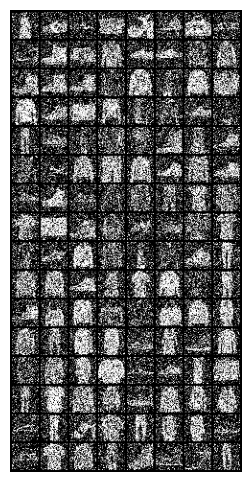

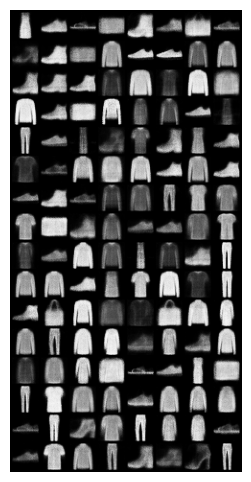

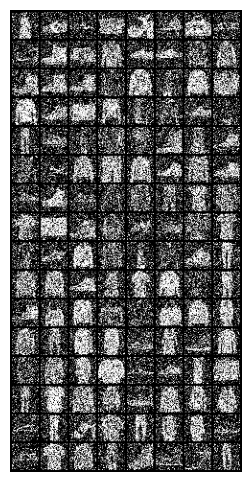


Test set: Average loss: 846.4624

Train Epoch: 22 [0/60000 (0%)]	Loss: 1.071519
Train Epoch: 22 [12800/60000 (21%)]	Loss: 1.073050
Train Epoch: 22 [25600/60000 (43%)]	Loss: 1.087006
Train Epoch: 22 [38400/60000 (64%)]	Loss: 1.086050
Train Epoch: 22 [51200/60000 (85%)]	Loss: 1.083690

Test set: Average loss: 846.8241

Train Epoch: 23 [0/60000 (0%)]	Loss: 1.082726
Train Epoch: 23 [12800/60000 (21%)]	Loss: 1.081366
Train Epoch: 23 [25600/60000 (43%)]	Loss: 1.086642
Train Epoch: 23 [38400/60000 (64%)]	Loss: 1.071560
Train Epoch: 23 [51200/60000 (85%)]	Loss: 1.077214

Test set: Average loss: 846.9784

Train Epoch: 24 [0/60000 (0%)]	Loss: 1.067191
Train Epoch: 24 [12800/60000 (21%)]	Loss: 1.066777
Train Epoch: 24 [25600/60000 (43%)]	Loss: 1.083794
Train Epoch: 24 [38400/60000 (64%)]	Loss: 1.087807
Train Epoch: 24 [51200/60000 (85%)]	Loss: 1.075462

Test set: Average loss: 846.4901

Train Epoch: 25 [0/60000 (0%)]	Loss: 1.081113
Train Epoch: 25 [12800/60000 (21%)]	Loss: 1.092493
Train Epoch: 

In [16]:
# Note that you should still count loss between not noised image and your prediction.
# Compute the testing loss

lr = 0.001
momentum = 1e-5
best_loss = 1000.0 # something large
noise = True

# initialize model
denoise_autoencoder = Autoencoder()
denoise_autoencoder.to(device)

# Initialize the optimizer
optimizer = torch.optim.Adam(denoise_autoencoder.parameters(), lr=lr, weight_decay=momentum) # Adam optimizer
criterion = nn.MSELoss()

# store train/test losses
train_losses = []
test_losses = []

# train the model
for epoch in range(1, EPOCHS + 1):
    start = time.time()
    model = train(denoise_autoencoder, trainloader_noise, optimizer, criterion, epoch=epoch, noise=noise, device=device)
    test_loss = test(model, testloader_noise, noise=noise, show_plot=epoch%10 == 1, device=device)

    # store losses
    if test_loss < best_loss:
        best_loss = test_loss
        if noise:
            torch.save(model.state_dict(), 'best_fc_denoising_autoencoder.pth')
        else:
            torch.save(model.state_dict(), 'best_fc_autoencoder.pth')

    test_losses.append(test_loss)

print('The best(lowest) achieved loss: {:.3f}\n'.format(best_loss))


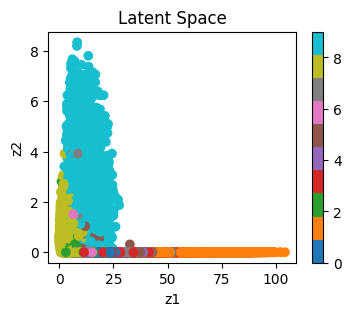

In [17]:
# Plot the latent space
plot_latent(model, trainloader, num_batches=BATCH_SIZE, path=f'{RESULTS_DIR}ae_latent_with_noise.png', device=device)

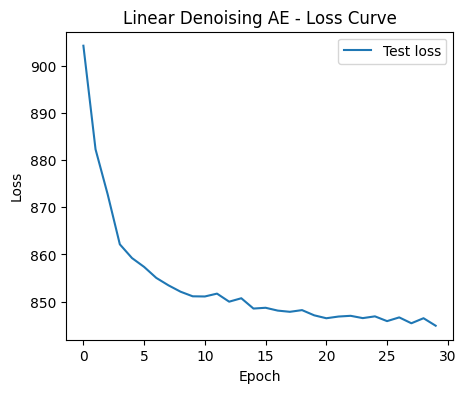

In [18]:
# Plot the loss curve
plot_loss(test_losses, label='Linear Denoising AE - Loss Curve', path=RESULTS_DIR+'ae_loss_curve_with_noise.png')

**Describe how has the performance of the model changed.**

The linear encoder-decoder AE network demonstrates the ability to effectively encode by transformation the salient information of the input data into a lower-dimensional latent space, Z, through transformations. This results in good preliminary outcomes, often visible in less than 30 epochs. However, it is also noticeable that the results can be blurry and lack certain details. This might be a consequence of the loss function used, as the Mean Squared Error (MSE) loss tries to minimize the difference between the output and input of the network on a pixel level.

MSE loss is highly sensitive to outliers and large errors. In order to minimize the MSE loss, the model tends to focus on reducing these large errors first, often at the expense of preserving high-frequency details, such as edges, textures, and patterns, in the images. These high-frequency components are crucial for the perception of image sharpness and quality. Moreover, the MSE loss function assumes that the errors are independent and identically distributed, which might not be the case for images. In natural images, the pixels are highly correlated with their neighbors, and these spatial dependencies are not explicitly considered by the MSE loss.

In contrast, the denoising autoencoder appears to struggle with learning how to recover the underlying structures of the data in order to minimize loss. The denoising autoencoder is a modification designed to prevent the network from simply learning an identity function, where the input and output are the same. This issue can arise when the encoder is too large and powerful, causing it to memorize the data instead of performing meaningful representation learning or dimensionality reduction.

Adding noise to the data can be seen as a form of regularization, encouraging the encoder to capture the salient features of the input data without resorting to memorization. However, the results of this experiment have not shown the expected improvements. This could be due to the choice of optimizer, the loss function, or potential issues in the implementation of the concatenation and subsequent clipping of noise and original data.

## Task 3: Implement a Convolutional Autoencoder

In [19]:

class ConvEncoder(nn.Module):
    """ Convolutional Encoder network for the Autoencoder"""

    def __init__(self):
        super(ConvEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5), # in: 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(4), # added batch normalization
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Flatten(),
            nn.Linear(3200, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

class ConvDecoder(nn.Module):
    """ Convolutional Decoder network for the Autoencoder"""

    def __init__(self):
        super(ConvDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(10, 400),
            nn.ReLU(),
            nn.Linear(400, 4000),
            nn.ReLU(),
            nn.Unflatten(1, (10, 20, 20)),
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            nn.Tanh() # out: 28x28
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

class ConvAutoencoder(nn.Module):
    """ Convolutional Autoencoder network"""

    def __init__(self, input_shape=(28, 28)):
        super(ConvAutoencoder, self).__init__()
        self.input_shape = input_shape
        self.encoder = ConvEncoder()
        self.decoder = ConvDecoder()

    def forward(self, x):
        x = x.view(x.size(0), 1, self.input_shape[0], self.input_shape[1])
        z = self.encoder(x)
        x = self.decoder(z)
        x = x.view(-1, 28*28)
        return x

In [20]:
# 3.1 mplement a convolutional autoencoder using the class torch.nn.Module4 from pytorch. Use the provided starter code as a template.
conv_autoencoder = ConvAutoencoder()
conv_autoencoder.to(device)

print(conv_autoencoder)

ConvAutoencoder(
  (encoder): ConvEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=3200, out_features=10, bias=True)
      (8): Softmax(dim=1)
    )
  )
  (decoder): ConvDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=4000, bias=True)
      (3): ReLU()
      (4): Unflatten(dim=1, unflattened_size=(10, 20, 20))
      (5): ConvTranspose2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
      (6): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU

### Train Convolutional Autoencoder

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.043223
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.137484
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.112591
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.107146
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.100862


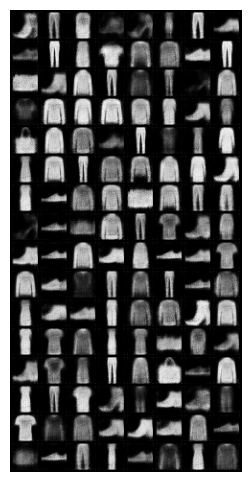

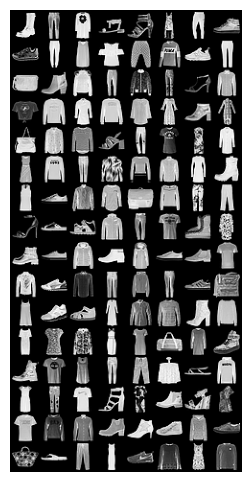


Test set: Average loss: 75.3443

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.095079
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.088669
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.088065
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.087744
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.073570

Test set: Average loss: 64.4187

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.074663
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.077660
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.072576
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.076591
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.066039

Test set: Average loss: 57.3122

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.076947
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.072990
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.063304
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.063269
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.059027

Test set: Average loss: 54.4340

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.067565
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.076471
Train Epoch: 5 [25600/60000 (43%)]

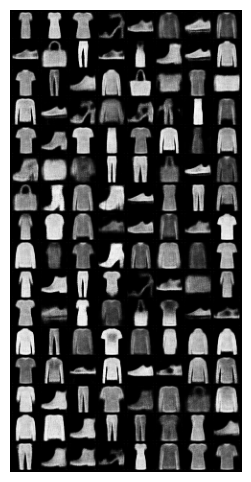

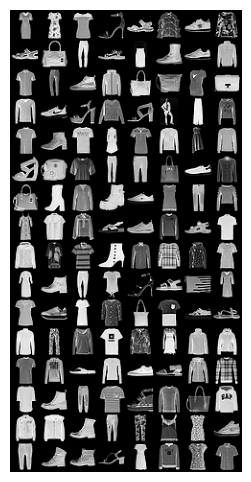


Test set: Average loss: 45.4541

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.055807
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.058694
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.052632
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.056155
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.052246

Test set: Average loss: 51.7300

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.057072
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.055415
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.056577
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.057673
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.060038

Test set: Average loss: 44.8738

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.056031
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.061347
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.052671
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.051276
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.057940

Test set: Average loss: 49.4132

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.060953
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.065781
Train Epoch: 15 [

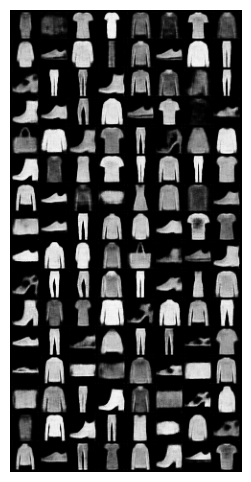

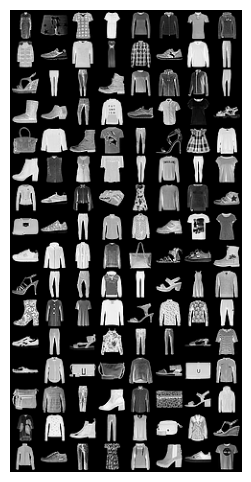


Test set: Average loss: 46.8671

Train Epoch: 22 [0/60000 (0%)]	Loss: 0.059648
Train Epoch: 22 [12800/60000 (21%)]	Loss: 0.052276
Train Epoch: 22 [25600/60000 (43%)]	Loss: 0.058051
Train Epoch: 22 [38400/60000 (64%)]	Loss: 0.056831
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.053056

Test set: Average loss: 46.3496

Train Epoch: 23 [0/60000 (0%)]	Loss: 0.054500
Train Epoch: 23 [12800/60000 (21%)]	Loss: 0.051899
Train Epoch: 23 [25600/60000 (43%)]	Loss: 0.056021
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.055649
Train Epoch: 23 [51200/60000 (85%)]	Loss: 0.044816

Test set: Average loss: 45.1102

Train Epoch: 24 [0/60000 (0%)]	Loss: 0.052892
Train Epoch: 24 [12800/60000 (21%)]	Loss: 0.051522
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.049276
Train Epoch: 24 [38400/60000 (64%)]	Loss: 0.049968
Train Epoch: 24 [51200/60000 (85%)]	Loss: 0.058133

Test set: Average loss: 45.0428

Train Epoch: 25 [0/60000 (0%)]	Loss: 0.054241
Train Epoch: 25 [12800/60000 (21%)]	Loss: 0.050357
Train Epoch: 25 [

In [21]:
# 5. Report the loss on the training split for each epoch, and every ten epochs on the test set
lr = 0.001
momentum = 1e-5
best_loss = 1000.0 # something large
noise = False

# Initialize the optimizer
optimizer = torch.optim.Adam(conv_autoencoder.parameters(), lr=lr, weight_decay=momentum) # Adam optimizer
criterion = nn.MSELoss()

# store train/test losses
train_losses = []
test_losses = []

# train the model
for epoch in range(1, EPOCHS + 1):
    start = time.time()
    model = train(conv_autoencoder, trainloader, optimizer, criterion, epoch=epoch, noise=noise, device=device)
    test_loss = test(model, testloader, noise=noise, show_plot=epoch%10 == 1, device=device)
    # store losses
    if test_loss < best_loss:
        best_loss = test_loss
        if noise:
            torch.save(model.state_dict(), 'best_cnn_denoising_autoencoder.pth')
        else:
            torch.save(model.state_dict(), 'best_cnn_autoencoder.pth')
    test_losses.append(test_loss)
print('The best(lowest) achieved loss: {:.3f}\n'.format(best_loss))


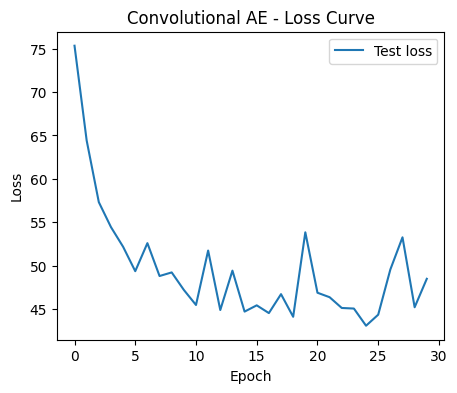

In [22]:
# Plot the loss curve
plot_loss(test_losses, label='Convolutional AE - Loss Curve', path=RESULTS_DIR+'aeconv_loss_curve.png')

**3.5 Compare the performance of this model to the model from the prior task**

* The model with Convolutional Layers demonstrates a greater capacity for learning patterns from high-dimensional, 2D spatial data, as the learned filters in a convolutional neural network are designed to recognize more complex local patterns. In contrast, linear models are less equipped to handle this task.
* Upon visualizing the learned lower-dimensional latent space Z of the encoder with linear layers, it is evident that the latent space scatter plots per class exhibit a linear structure. This suggests that the linear encoder also primarily captures linear relationships in the data.
* In contrast, when examining the components of the latent space of the convolutional encoder, it is clear that the convolutional layers have facilitated a more effective projection of the encoded input values into the latent space. The presence of distinct, separable clusters in the convolutional encoder's latent space indicates that this model is able to capture more complex, non-linear relationships in the data.
* Furthermore, the expressiveness and capacity of the convolutional encoder are shown to be superior to the linear encoder. This may be due to the limitations of a linear transformation when mapping input data into the latent space, where the relationship between the input features and the latent space is strictly linear. As a result, each class is also only represented by a linearly separable region, which may not reflect the true underlying patterns in the input data. The convolutional encoder, however, is not restricted by such linear assumptions and is therefore more capable of transforming the input data into a non-linear latent space. The result visible in the training and testing loss curve is also reflected in the reconstruction of the decoder, which shows higher capacity to reconstruct output images close to the input data distribution than the linear encoder.

## Train Denoising Convolutional Autoencoder

In [23]:
# train the model with noise
denoise_conv_autoencoder = ConvAutoencoder()
denoise_conv_autoencoder.to(device)

ConvAutoencoder(
  (encoder): ConvEncoder(
    (encoder): Sequential(
      (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=3200, out_features=10, bias=True)
      (8): Softmax(dim=1)
    )
  )
  (decoder): ConvDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=4000, bias=True)
      (3): ReLU()
      (4): Unflatten(dim=1, unflattened_size=(10, 20, 20))
      (5): ConvTranspose2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
      (6): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306370
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.153751
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.110095
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.108150
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.100949


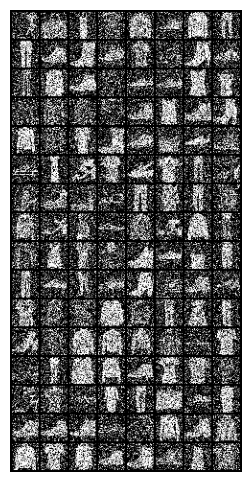

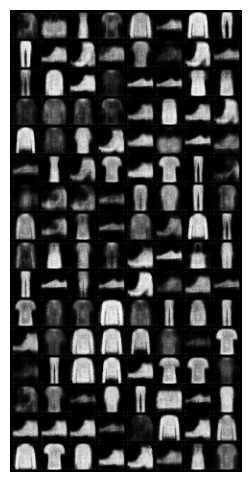

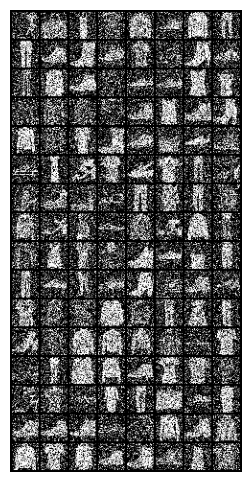


Test set: Average loss: 863.6517

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.092011
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.095103
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.083031
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.090555
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.092211

Test set: Average loss: 849.8091

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.078713
Train Epoch: 3 [12800/60000 (21%)]	Loss: 1.079280
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.081345
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.079680
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.070799

Test set: Average loss: 844.3004

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.076217
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1.069363
Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.066157
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.068002
Train Epoch: 4 [51200/60000 (85%)]	Loss: 1.067865

Test set: Average loss: 839.6457

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.075197
Train Epoch: 5 [12800/60000 (21%)]	Loss: 1.056677
Train Epoch: 5 [25600/60000 (4

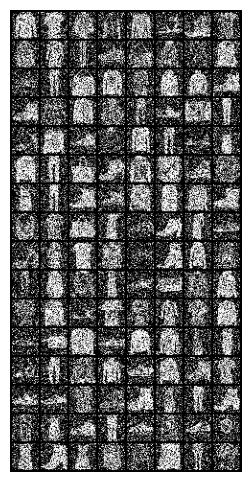

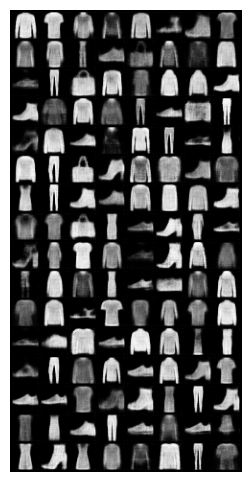

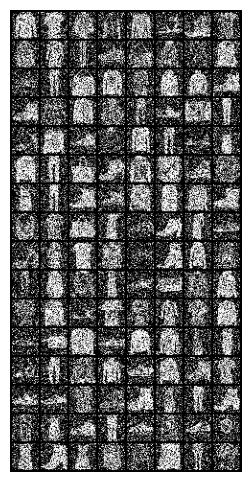


Test set: Average loss: 832.4842

Train Epoch: 12 [0/60000 (0%)]	Loss: 1.062387
Train Epoch: 12 [12800/60000 (21%)]	Loss: 1.066248
Train Epoch: 12 [25600/60000 (43%)]	Loss: 1.050627
Train Epoch: 12 [38400/60000 (64%)]	Loss: 1.057194
Train Epoch: 12 [51200/60000 (85%)]	Loss: 1.051498

Test set: Average loss: 830.6951

Train Epoch: 13 [0/60000 (0%)]	Loss: 1.060816
Train Epoch: 13 [12800/60000 (21%)]	Loss: 1.060175
Train Epoch: 13 [25600/60000 (43%)]	Loss: 1.056382
Train Epoch: 13 [38400/60000 (64%)]	Loss: 1.064459
Train Epoch: 13 [51200/60000 (85%)]	Loss: 1.051569

Test set: Average loss: 833.4578

Train Epoch: 14 [0/60000 (0%)]	Loss: 1.053036
Train Epoch: 14 [12800/60000 (21%)]	Loss: 1.055231
Train Epoch: 14 [25600/60000 (43%)]	Loss: 1.056628
Train Epoch: 14 [38400/60000 (64%)]	Loss: 1.061838
Train Epoch: 14 [51200/60000 (85%)]	Loss: 1.060928

Test set: Average loss: 834.2687

Train Epoch: 15 [0/60000 (0%)]	Loss: 1.060816
Train Epoch: 15 [12800/60000 (21%)]	Loss: 1.051621
Train Epoch: 

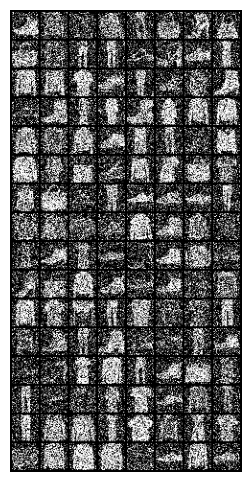

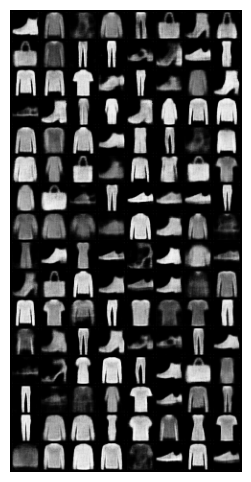

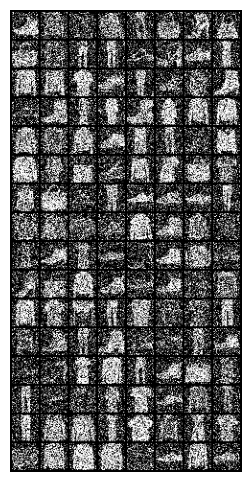


Test set: Average loss: 829.2717

Train Epoch: 22 [0/60000 (0%)]	Loss: 1.055714
Train Epoch: 22 [12800/60000 (21%)]	Loss: 1.062424
Train Epoch: 22 [25600/60000 (43%)]	Loss: 1.058789
Train Epoch: 22 [38400/60000 (64%)]	Loss: 1.053203
Train Epoch: 22 [51200/60000 (85%)]	Loss: 1.068832

Test set: Average loss: 828.0034

Train Epoch: 23 [0/60000 (0%)]	Loss: 1.054972
Train Epoch: 23 [12800/60000 (21%)]	Loss: 1.050587
Train Epoch: 23 [25600/60000 (43%)]	Loss: 1.060902
Train Epoch: 23 [38400/60000 (64%)]	Loss: 1.045337
Train Epoch: 23 [51200/60000 (85%)]	Loss: 1.046700

Test set: Average loss: 829.6017

Train Epoch: 24 [0/60000 (0%)]	Loss: 1.053823
Train Epoch: 24 [12800/60000 (21%)]	Loss: 1.047332
Train Epoch: 24 [25600/60000 (43%)]	Loss: 1.060218
Train Epoch: 24 [38400/60000 (64%)]	Loss: 1.061543
Train Epoch: 24 [51200/60000 (85%)]	Loss: 1.056553

Test set: Average loss: 830.6038

Train Epoch: 25 [0/60000 (0%)]	Loss: 1.057496
Train Epoch: 25 [12800/60000 (21%)]	Loss: 1.058241
Train Epoch: 

In [24]:
# 5. Report the loss on the training split for each epoch, and every ten epochs on the test set
lr = 0.001
momentum = 1e-5
best_loss = 1000. # something large
noise = True

# Initialize the optimizer
optimizer = torch.optim.Adam(denoise_conv_autoencoder.parameters(), lr=lr, weight_decay=momentum) # Adam optimizer
criterion = nn.MSELoss()

# store train/test losses
train_losses = []
test_losses = []

# train the model
for epoch in range(1, EPOCHS + 1):
    start = time.time()
    model = train(denoise_conv_autoencoder, trainloader_noise, optimizer, criterion, epoch=epoch, noise=noise, device=device)
    test_loss = test(model, testloader_noise, noise=noise, show_plot=epoch%10 == 1, device=device)
    # store losses
    if test_loss < best_loss:
        best_loss = test_loss
        if noise:
            torch.save(model.state_dict(), 'best_denoise_cnn_denoising_autoencoder.pth')
        else:
            torch.save(model.state_dict(), 'best_cnn_autoencoder.pth')
    # Add test losses per epoch
    test_losses.append(test_loss)

print('The best(lowest) achieved loss: {:.3f}\n'.format(best_loss))


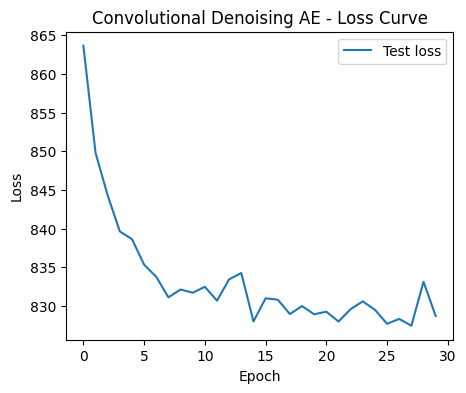

In [25]:
# Plot the loss curve
plot_loss(test_losses, label='Convolutional Denoising AE - Loss Curve', path=RESULTS_DIR+'aeconv_loss_curve_with_noise.png')